# Final Project 
ron dagani 318170917

elay sason 322995358

In [0]:
pip install pyspark

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
#from google.colab import drive
#drive.mount("/content/drive")

In [0]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from pyspark.sql.types import *
import pyspark as ps
from pyspark.sql.functions import countDistinct
from pyspark.sql.functions import rand
from pyspark.sql.functions import col,explode
import os
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.types import StructType

In [0]:
your_unique_name="elay_roni_PROJ" # Use this string to look for your app in the Spark UI
if your_unique_name=="noam_hw2":
    raise Exception("Please use your own name")

In [0]:
spark = SparkSession.builder.appName("ron_and_elay").getOrCreate()
spark.conf.set("spark.sql.caseSensitive", "true")
pre = "/mnt/lab94290/inputdata/"
prefix = "/mnt/lab94290/inputdata/"

In [0]:
fname_test_data = "bids_20k_no_bidfloor.json" 
fname = "2_2.gz"
fname_ref = "bids_12.json"

In [0]:
from pyspark.sql.types import MapType

# At least one file has duplicate key, failing the reading of dataframe when it has to infer the schema.
# So I read a known well defined file (fname_ref), learn the schema from it, and then use the schema to read
# the full file. When given explicit schema, Spark can handle duplicate keys

# inferred = spark.read.json(fname_ref)
# #inferred.printSchema()

# # NOTE: the json() command can accept a list of json files. It does not work with *.gz files 
# bids = spark.read.schema(inferred.schema).json(str(fname))

In [0]:
fname_ref = pre + "bids_12.json"
inferred = spark.read.json(fname_ref)

In [0]:
# bids = spark.read.schema(inferred.schema).json(pre +"for_csv")
#for i in range(0,7):###############
#    bids = bids.union(spark.read.schema(inferred.schema).json(pre + f"requestLog_D_919539.log.tar_{i}.json"))
filelist = [ prefix + 'requestLog_D_919539.log.tar_' + str(i) + ".json" for i in [0,6]]
fname_ref = "bids_12.json"
inferred = spark.read.json("/mnt/lab94290/inputdata/"+fname_ref)
bids = spark.read.schema(inferred.schema).json(filelist)


## **1. Preprocessing**


Flattenning the data:

In [0]:
def json_flattening(schema, prename=None):
    columns = []
    for field in schema.fields:
        name = prename + '.' + field.name if prename else field.name
        dtype = field.dataType
        if isinstance(dtype, ArrayType):
            dtype = dtype.elementType

        if isinstance(dtype, StructType):
            columns += json_flattening(dtype, name)
        else:
            columns.append(name)
    
    return columns

In [0]:
out = json_flattening(inferred.select("device").schema)
device_flat_df = inferred.select(out)
out = [s.replace(".", "_") for s in out]
for column in device_flat_df:
    device_flat_df = device_flat_df.withColumnRenamed(str(column)[8:-2], out[0])
    out = out[1:]


In [0]:
bids = bids.drop('unparseable')

Model:

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
from pyspark.sql.functions import udf
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.sql.functions import lit
from pyspark.sql.window import Window as W
from pyspark.sql import functions as F
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.functions import vector_to_array

sc=spark.sparkContext
sqlContext = SQLContext(sc)


/databricks/spark/python/pyspark/sql/context.py:117: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


### Choosing parameters:

we chose the parameters: 
imp_position, 
imp_secure, 
device_geo_type, 
device_connectiontype, 
device_geo_lat,
device_geo_lon,
imp_banner_pos,
imp_banner_h,
spots_banner_w,            device_os - categorial.
   

We tried picking parameters that tells us as much information about the imp and about the device so we could find the patterns.In addition, we picked those who had less null values, and in the categorial ones, we had to make sure the runnig time and memory would work - so we had to pick those with limited and small number of possible values.

onehot for the categorial parameters

In [0]:
def onehoting(colmn_name, data,features):
    indexer = StringIndexer(inputCol=colmn_name, 
                          outputCol=colmn_name+"_numeric").fit(data)
    indexed_df = indexer.transform(data)
    indexed_df  = indexed_df.drop(colmn_name)
    features.remove(colmn_name)
    encoder = OneHotEncoder(inputCols=[colmn_name+"_numeric"], outputCols=['class_onehot'+colmn_name])
    df_onehot = encoder.fit(indexed_df).transform(indexed_df)
    df_col_onehot = df_onehot.select('*', vector_to_array('class_onehot'+colmn_name).alias('col_onehot'+colmn_name))
    num_categories = len(df_col_onehot.first()['col_onehot'+colmn_name])   # 3
    cols_expanded = [(F.col('col_onehot'+colmn_name)[i]) for i in range(num_categories)]
    df_cols_onehot = df_col_onehot.select(*features, *cols_expanded)
    # for i in :
    features.extend(cols_expanded)
    return features, df_cols_onehot

In [0]:
bids = bids.drop('unparseable').drop('domain')
out = json_flattening(bids.select('device','imp','location').schema)
out.remove('device.h')
out.remove('imp.banner.w')

flat_df = bids.select(out)
out = [s.replace(".", "_") for s in out]

for column in flat_df:
  flat_df = flat_df.withColumnRenamed(str(column)[8:-2], out[0])
  out = out[1:]
cols = ('imp_instl','imp_ext_wopv','imp_ext_viewabilityvendors','imp_ext_to','imp_ext_skadn_versions','imp_ext_skadn_version','imp_ext_skadn_sourceapp','imp_ext_skadn_skadnetids','imp_bidfloorcur','imp_banner_mimes','imp_banner_btype','imp_banner_battr','device_pxratio','device_ppi','device_lmt','device_w','device_ext_atts','device_ext_atts','device_ext_is_app','device_hwv')
flat_df = flat_df.drop(*cols)


In [0]:
def index(bids,test):   
    bids = bids.drop('unparseable').drop('domain')
    out = json_flattening(bids.schema)
    flat_df = bids.select(out)
    
    out = [s.replace(".", "_") for s in out]
    flat_df = flat_df.toDF(*out)
    for column in flat_df.toDF(*out):
        flat_df = flat_df.withColumnRenamed(str(column)[8:-2], out[0])
        out = out[1:]
    cols = ('imp_instl','imp_ext_wopv','imp_ext_viewabilityvendors','imp_ext_to','imp_ext_skadn_versions','spots_ext_to','spots_ext_skadn_skadnetids','spots_ext_skadn_sourceapp','spots_ext_skadn_version','spots_ext_skadn_versions','spots_ext_skadn_versions','imp_ext_skadn_version','imp_ext_skadn_sourceapp','imp_ext_skadn_skadnetids','imp_bidfloorcur','imp_banner_mimes','imp_banner_btype','imp_banner_battr','device_pxratio','device_ppi','device_lmt','device_w','device_ext_atts','device_ext_atts','device_ext_is_app','device_hwv')
    flat_df = flat_df.drop(*cols)
    indexed_df = flat_df.select(flat_df.imp_position.getItem(0).alias('B_Position'),
            flat_df.imp_secure.getItem(0).alias('B_Secure'),
            flat_df.device_geo_type.alias('D_Geo_Type'),
            flat_df.device_geo_lon.alias('D_Geo_Lon'),
            flat_df.device_connectiontype.alias('D_Connection_Type'),
            flat_df.device_geo_lat.alias('D_Lat'),
            flat_df.device_os.alias('device_os'),
            flat_df.imp_banner_pos.getItem(0).alias('imp_banner_pos'),
            flat_df.imp_banner_h.getItem(0).alias('B_Height'),
            flat_df.spots_banner_w.getItem(0).alias('B_Width'),
            flat_df.imp_banner_h.getItem(0).alias('imp_banner_h'))
    return indexed_df
indexed_df = index(bids,False)

In [0]:
def index(bids,test):   
    bids = bids.drop('unparseable').drop('domain')
    out = json_flattening(bids.schema)
    flat_df = bids.select(out)
    
    out = [s.replace(".", "_") for s in out]
    flat_df = flat_df.toDF(*out)
    for column in flat_df.toDF(*out):
        flat_df = flat_df.withColumnRenamed(str(column)[8:-2], out[0])
        out = out[1:]
    cols = ('imp_instl','imp_ext_wopv','imp_ext_viewabilityvendors','imp_ext_to','imp_ext_skadn_versions','spots_ext_to','spots_ext_skadn_skadnetids','spots_ext_skadn_sourceapp','spots_ext_skadn_version','spots_ext_skadn_versions','spots_ext_skadn_versions','imp_ext_skadn_version','imp_ext_skadn_sourceapp','imp_ext_skadn_skadnetids','imp_bidfloorcur','imp_banner_mimes','imp_banner_btype','imp_banner_battr','device_pxratio','device_ppi','device_lmt','device_w','device_ext_atts','device_ext_atts','device_ext_is_app','device_hwv')
    flat_df = flat_df.drop(*cols)
    indexed_df = flat_df.select(flat_df.imp_position.getItem(0).alias('B_Position'),
            flat_df.imp_secure.getItem(0).alias('B_Secure'),
            flat_df.device_geo_type.alias('D_Geo_Type'),
            flat_df.device_geo_lon.alias('D_Geo_Lon'),
            flat_df.device_connectiontype.alias('D_Connection_Type'),
            flat_df.device_geo_lat.alias('D_Lat'),
            flat_df.device_os.alias('device_os'),
            flat_df.imp_banner_pos.getItem(0).alias('imp_banner_pos'),
            flat_df.imp_banner_h.getItem(0).alias('B_Height'),
            flat_df.spots_banner_w.getItem(0).alias('B_Width'),
            flat_df.imp_banner_h.getItem(0).alias('imp_banner_h'),
            flat_df.device_ip.alias('device_ip'))
    return indexed_df
indexed_df_outliers = index(bids,False)

## **2. Imputation**

We chose not to use other columns to impute our missing columns because we saw that when we want to impute a column with a related column, if our column is missing is likely that the other one will be as well.
As we can see with the instance of device os there two main values: android and ios. Therefore we chose to fill with andorid and ios according to the probability of each one. We choose this method because it's doesnt change the distribution of the variable and therefore it will not introduce bias into the analysis. Using only the most frequent method would ignored the whole 184985 records of ios and change the disburation.
For the numaric variables we chose the mean imputation method, as it makes sense to use it when the data is MCAR as the case with our numirical variables. we used lower case to prevent same meaning have different representations.

In [0]:
flat_df = flat_df.withColumn("device_os", f.lower(flat_df["device_os"]))
device_count = flat_df.groupBy("device_os").count()
device_count = device_count.withColumn("percentage", f.round(device_count["count"] / device_count.agg({"count": "sum"}).collect()[0][0] * 100, 2))
device_count.show()

+-----------------+------+----------+
|        device_os| count|percentage|
+-----------------+------+----------+
|          android|681325|     74.39|
|        apple mac|   568|      0.06|
|            kaios|     1|       0.0|
|             null| 26696|      2.91|
|           ipados|     8|       0.0|
|microsoft windows|   439|      0.05|
|            linux|   168|      0.02|
|              ios|206569|     22.55|
|        chrome os|    32|       0.0|
|            other|    16|       0.0|
|       windows 10|     2|       0.0|
|            tizen|     5|       0.0|
|           mac os|    42|       0.0|
|          unknown|     2|       0.0|
|       symbian os|     2|       0.0|
|        harmonyos|     2|       0.0|
|          fire os|     1|       0.0|
+-----------------+------+----------+



In [0]:
most_popular = device_count.sort('count').collect()[-1][0]
most_popular_freq = device_count.filter(f.col("device_os") == most_popular).select('percentage').collect()[0].percentage
second_most = device_count.sort('count').collect()[-2][0]

In [0]:
from pyspark.sql.functions import when, rand

indexed_df = indexed_df.withColumn("device_os", when(indexed_df["device_os"].isNull(), when(rand() < most_popular_freq, most_popular).otherwise(second_most)).otherwise(indexed_df["device_os"]))

In [0]:
cat2num = ['device_os']
features = list(indexed_df.columns)
for colmn_name in cat2num:
    features, indexed_df = onehoting(colmn_name, indexed_df, features)
indexed_df = indexed_df.select(*(col(c).cast("float").alias(c) for c in indexed_df.columns))
for i in list(indexed_df.columns):
    mean_val = indexed_df.select(f.mean(i)).rdd.flatMap(lambda x: x).collect()[0]
    indexed_df = indexed_df.na.fill(value=mean_val, subset=[i])

VectorAssembler and StandardScaler to features. Scaler is important in this case to normalize the larger variables and allow the variables with a smaller range to have a chance to impact after the pca.

In [0]:
va = VectorAssembler(inputCols=indexed_df.columns, outputCol='feature_train')
va_df = va.transform(indexed_df) #one hot vetor

In [0]:
scaler = StandardScaler(
    inputCol = 'feature_train', 
    outputCol = 'scaledFeatures',
    withMean = True,
    withStd = True
).fit(va_df)
final_df_scaled = scaler.transform(va_df)
final_df_scaled.show(6)

+----------+--------+----------+----------+-----------------+--------+--------------+--------+-------+------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+--------------------+--------------------+
|B_Position|B_Secure|D_Geo_Type| D_Geo_Lon|D_Connection_Type|   D_Lat|imp_banner_pos|B_Height|B_Width|imp_banner_h|col_onehotdevice_os[0]|col_onehotdevice_os[1]|col_onehotdevice_os[2]|col_onehotdevice_os[3]|col_onehotdevice_os[4]|col_onehotdevice_os[5]|col_onehotdevice_os[6]|col_onehotdevice_os[7]|col_onehotdevice_os[8]|col_onehotdevice_os[9]|col_onehotdevice_os[10]|col_onehotdevice_os[11]|col

## 3. Kmeans + PCA

In [0]:
n_components = 2
pca = PCA(
    k = n_components, 
    inputCol = 'scaledFeatures', 
    outputCol = 'pcaFeatures'
).fit(final_df_scaled)

df_pca = pca.transform(final_df_scaled)
print('Explained Variance Ratio', pca.explainedVariance.toArray())
df_pca.show(6)

Explained Variance Ratio [0.10100816 0.07213885]
+----------+--------+----------+----------+-----------------+--------+--------------+--------+-------+------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+--------------------+--------------------+--------------------+
|B_Position|B_Secure|D_Geo_Type| D_Geo_Lon|D_Connection_Type|   D_Lat|imp_banner_pos|B_Height|B_Width|imp_banner_h|col_onehotdevice_os[0]|col_onehotdevice_os[1]|col_onehotdevice_os[2]|col_onehotdevice_os[3]|col_onehotdevice_os[4]|col_onehotdevice_os[5]|col_onehotdevice_os[6]|col_onehotdevice_os[7]|col_onehotdevice_os[8]|col_

In [0]:
x_pca = df_pca[['pcaFeatures']].collect()
X_pca = np.array(x_pca)
first_pca = [x[0][0] for x in X_pca]
second_pca = [x[0][1] for x in X_pca]

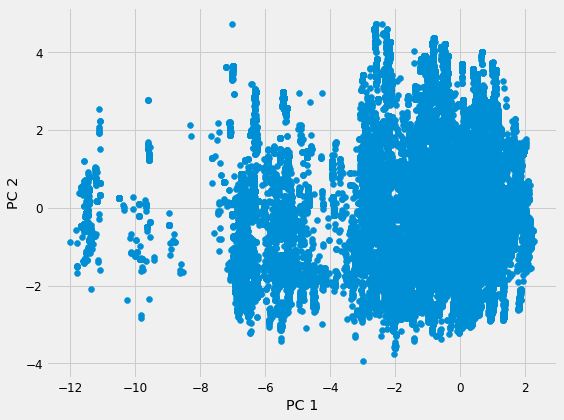

In [0]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12
plt.scatter(first_pca,second_pca)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.tight_layout()
plt.show()

Having a look at the pca result we can see that it seems that the data can be separated into 3 clusters and therefore we chose k = 3  for our kmeans later on.

#### **KMEANS**

In [0]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [0]:
KMeans_algo=KMeans(featuresCol='scaledFeatures', k=3)
KMeans_fit=KMeans_algo.fit(final_df_scaled)
output=KMeans_fit.transform(final_df_scaled)

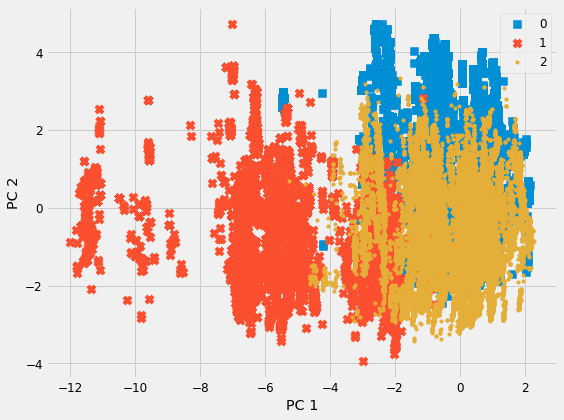

In [0]:
x_pca = df_pca[['pcaFeatures']].collect()
X_pca = np.array(x_pca)
first_pca = [x[0][0] for x in X_pca]
second_pca = [x[0][1] for x in X_pca]
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12
def plot_classes_pca(X_pca, y):
    markers = 's', 'x','.','*',"+"
    colors = list(plt.rcParams['axes.prop_cycle'])
    target = np.unique(y)
    for idx, (t, m) in enumerate(zip(target, markers)):
        subset = X_pca[y == t]
        plt.scatter(subset[:, 0], subset[:, 1], s = 50,
                    c = colors[idx]['color'], label = t, marker = m)

    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.legend(loc = 'upper right')
    plt.tight_layout()
    plt.show()
plot_classes_pca(X_pca, output[["prediction"]].collect())

We see that the big mass of points on the right got separated into 3 groups while the most of the data on the left got into one cluster. Our prior feel of  3 clusters got matched with the fact the most the point are located on the right so the k means couldn't get the 3 cluster we saw with our eyes.

In [0]:
evaluator = ClusteringEvaluator(featuresCol='scaledFeatures')
silhouette = evaluator.evaluate(output)
print(silhouette)

0.33078954515932


### Outliers
For the distance metric we chose the distance from the closest centroid and chose the 0.995 perecnatile meaning that 99.5 of the point of the cluster are closer than those outliers. we chose this methos because it take exacly the 0.5% that are as far away as exist so they probably different then the ones that are close to the center.

In [0]:
cen = list(enumerate([centroid.tolist() for centroid in KMeans_fit.clusterCenters()]))
cen_places = spark.createDataFrame(cen, ['prediction','centroid'])
new_df = output.join(cen_places, on='prediction', how='left')
dist = f.udf(lambda sample, centroid: float(sample.squared_distance(centroid)),FloatType())
new_df = new_df.withColumn('dist' ,dist(f.col('scaledFeatures'),f.col('centroid')))
outliers_parttion = new_df.approxQuantile('dist', [0.995], 0)[0]
ouliers_col_df = f.udf(lambda dist: 1 if dist > outliers_parttion else 0, IntegerType())
new_df_kmeans = new_df.withColumn('y_pred',ouliers_col_df(f.col('dist')))
outliers_df_kmeans = new_df_kmeans.filter(f.col("y_pred") == 1)
print((outliers_df_kmeans.count()/flat_df.count())*100)

0.4446007000932438


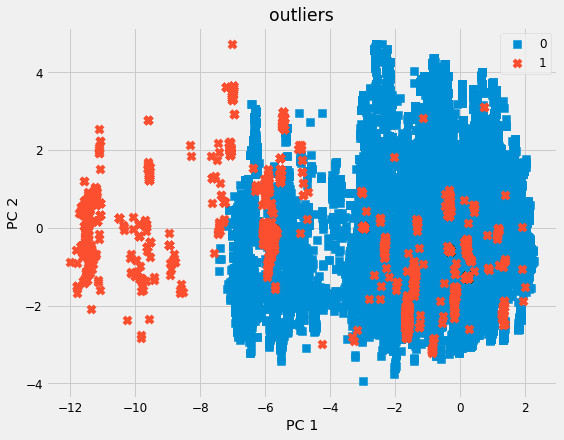

In [0]:
x_pca = df_pca[['pcaFeatures']].collect()
X_pca = np.array(x_pca)
first_pca = [x[0][0] for x in X_pca]
second_pca = [x[0][1] for x in X_pca]
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12
def plot_classes_pca(X_pca, y):
    markers = 's', 'x','.','*',"+"
    colors = list(plt.rcParams['axes.prop_cycle'])
    target = np.unique(y)
    for idx, (t, m) in enumerate(zip(target, markers)):
        subset = X_pca[y == t]
        plt.scatter(subset[:, 0], subset[:, 1], s = 50,
                    c = colors[idx]['color'], label = t, marker = m)

    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.legend(loc = 'upper right')
    plt.tight_layout()
    plt.title('outliers')
    plt.show()
plot_classes_pca(X_pca, new_df_kmeans[["y_pred"]].collect())

We can see that all the point on the left side are classified as outliers, which makes sense as they are in much smaller numbers compared to the mass on the right and center. Furthermore, the higher point points are classified as outliers as well a fact that makes sense because that looking at them they seem out of place from the mass.

### second model

We chose to use BIsectingKmeans for our second model. The way this algorithm works it is initialize K centroids and run regular k means with k = 2, choose one of the clusters( there are few ways to do so max variance, number of members in the cluster and more) and repeat this step until K clusters are achived. We chose it for its efficiency and the fact it's less sensitive to initial starting point compared to regular kmeans.

In [0]:
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Trains a bisecting k-means model.
bkm = BisectingKMeans(featuresCol='scaledFeatures').setK(3).setSeed(1)
model = bkm.fit(final_df_scaled)

# Make predictions
predictions = model.transform(final_df_scaled)

In [0]:
evaluator2 = ClusteringEvaluator(featuresCol='scaledFeatures')
silhouette2 = evaluator2.evaluate(predictions)
print(silhouette2)

0.1257934051777131


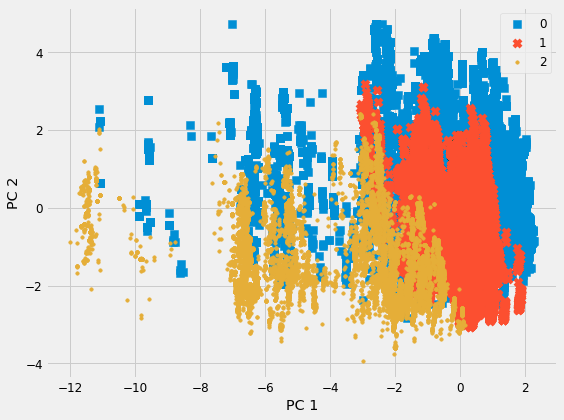

In [0]:
x_pca = df_pca[['pcaFeatures']].collect()
X_pca = np.array(x_pca)
first_pca = [x[0][0] for x in X_pca]
second_pca = [x[0][1] for x in X_pca]
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12
def plot_classes_pca(X_pca, y):
    markers = 's', 'x','.','*',"+"
    colors = list(plt.rcParams['axes.prop_cycle'])
    target = np.unique(y)
    for idx, (t, m) in enumerate(zip(target, markers)):
        subset = X_pca[y == t]
        plt.scatter(subset[:, 0], subset[:, 1], s = 50,
                    c = colors[idx]['color'], label = t, marker = m)

    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.legend(loc = 'upper right')
    plt.tight_layout()
    plt.show()
plot_classes_pca(X_pca, predictions[["prediction"]].collect())

We can see that the BIKmeans results into clusters thats are inside each other and there are no apparent separation between them. Three of the clusters are from the right mass to less few.

smiliarly, because it has the same meanning in the space, for the distance metric we chose the distance from the closest centroid and chose the 0.995 perecnatile meaning that 99.5 of the point of the cluster are closer than those outliers. we chose this methos because it take exacly the 0.5% that are as far away as exist so they probably different then the ones that are close to the center.

In [0]:
cen = list(enumerate([centroid.tolist() for centroid in model.clusterCenters()]))
cen_places = spark.createDataFrame(cen, ['prediction','centroid'])
new_df = predictions.join(cen_places, on='prediction', how='left')
dist = f.udf(lambda sample, centroid: float(sample.squared_distance(centroid)),FloatType())
new_df = new_df.withColumn('dist' ,dist(f.col('scaledFeatures'),f.col('centroid')))
outliers_parttion = new_df.approxQuantile('dist', [0.995], 0)[0]
ouliers_col_df = f.udf(lambda dist: 1 if dist > outliers_parttion else 0, IntegerType())
new_df_bk = new_df.withColumn('outliers_pred',ouliers_col_df(f.col('dist')))
second_try = new_df_bk.filter(f.col("outliers_pred") == 1)
print((second_try.count()/flat_df.count())*100)

0.5000666027571358


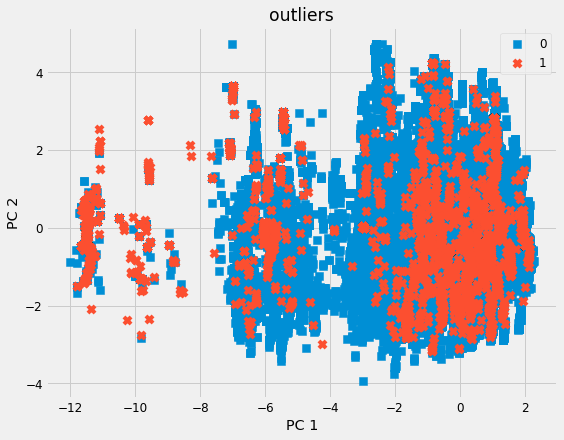

In [0]:
x_pca = df_pca[['pcaFeatures']].collect()
X_pca = np.array(x_pca)
first_pca = [x[0][0] for x in X_pca]
second_pca = [x[0][1] for x in X_pca]
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12
def plot_classes_pca(X_pca, y):
    markers = 's', 'x','.','*',"+"
    colors = list(plt.rcParams['axes.prop_cycle'])
    target = np.unique(y)
    for idx, (t, m) in enumerate(zip(target, markers)):
        subset = X_pca[y == t]
        plt.scatter(subset[:, 0], subset[:, 1], s = 50,
                    c = colors[idx]['color'], label = t, marker = m)

    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.legend(loc = 'upper right')
    plt.tight_layout()
    plt.title('outliers')
    plt.show()
plot_classes_pca(X_pca, new_df_bk[["outliers_pred"]].collect())

We can see that the outliers of the BIKmeans are very similar to the one of the Kmeans where the small number of the point on the left are classified as outliers compared to the mass of point on right side

We chose to show as well the result of the Gaussian mixture models (GMM) as well in order to see the difference between them, while Kmeans is deterministic GMM is probabilistic so a comparison between them can be interesting.

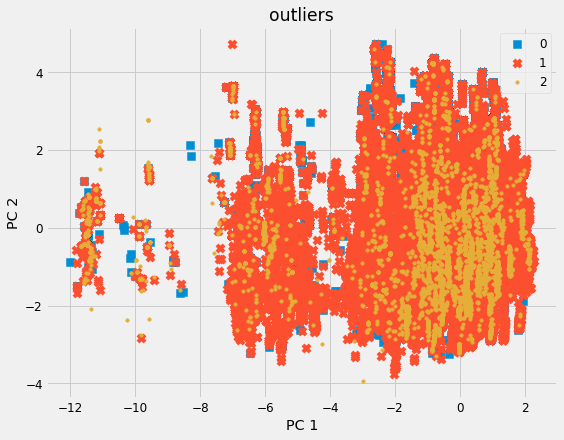

In [0]:
from pyspark.ml.clustering import GaussianMixture
from pyspark.ml.evaluation import ClusteringEvaluator

gm = GaussianMixture(k=3, tol=0.0001, seed=10,featuresCol='scaledFeatures')
model = gm.fit(final_df_scaled)
output2 = model.transform(final_df_scaled)
#model.gaussiansDF.show(truncate=False)
plot_classes_pca(X_pca, output2[["prediction"]].collect())

Comparing the results we see that the GMM has similar results.

In [0]:
evaluator2 = ClusteringEvaluator(featuresCol='scaledFeatures')
silhouette2 = evaluator2.evaluate(output2)
print(silhouette2)

0.6149450620800605


##results exploration 
we compered the numerical parameters using describe

In [0]:
indexed_df.select(["B_Position","B_Secure","D_Geo_Lon","D_Lat","imp_banner_pos","B_Height","B_Width","imp_banner_h"]).describe().show()
outliers_df_kmeans.select(["B_Position","B_Secure","D_Geo_Lon","D_Lat","imp_banner_pos","B_Height","B_Width","imp_banner_h"]).describe().show()

+-------+------------------+------------------+-------------------+-----------------+------------------+------------------+------------------+------------------+
|summary|        B_Position|          B_Secure|          D_Geo_Lon|            D_Lat|    imp_banner_pos|          B_Height|           B_Width|      imp_banner_h|
+-------+------------------+------------------+-------------------+-----------------+------------------+------------------+------------------+------------------+
|  count|            915878|            915878|             915878|           915878|            915878|            915878|            915878|            915878|
|   mean|0.5261552302817624|0.7719021946631528|-10.223863437894568|20.13042975368954|0.5263103905192489| 143.1969280465293| 319.2048257302031| 143.1969280465293|
| stddev|1.4741099862717673|0.4021589936003567|  58.28116706499517|18.90730901380921| 1.464579984138935|129.82377517640822|55.261703034781895|129.82377517640822|
|    min|               0.0|

In [0]:
p_outliers = outliers_df_kmeans.toPandas()
p_alldata = indexed_df.toPandas()

/databricks/spark/python/pyspark/sql/pandas/conversion.py:119: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field feature_train. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


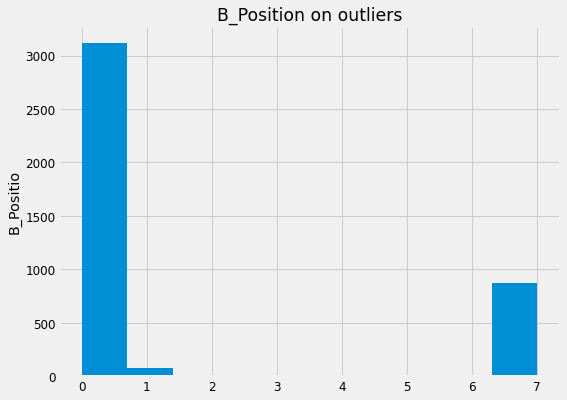

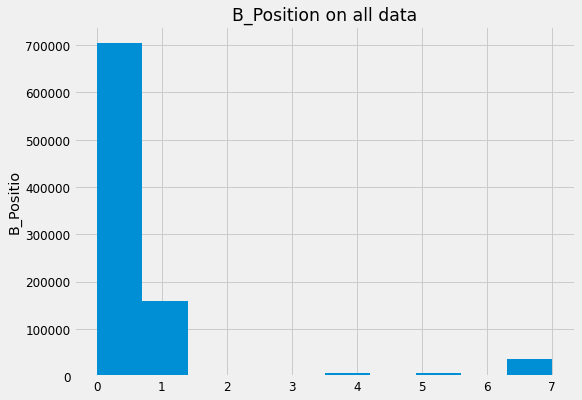

In [0]:
plt.hist(p_outliers["B_Position"])
plt.title("B_Position on outliers")
plt.ylabel("B_Positio")
plt.show()
plt.clf()
plt.hist(p_alldata["B_Position"])
plt.title("B_Position on all data")
plt.ylabel("B_Positio")
plt.show()

B_position - We can see that the general data is way more concentrated around 0 than the outliers which have large amount at 7. Therefore large postion can be used as a indication.

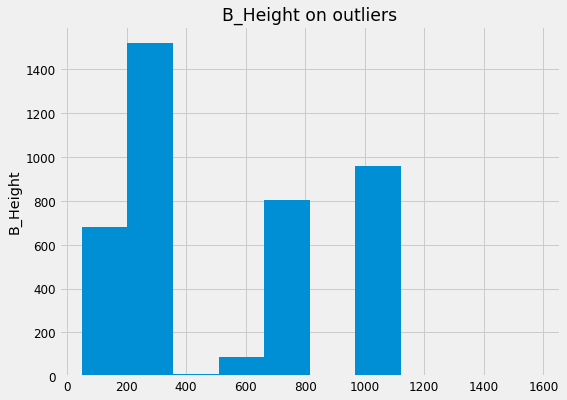

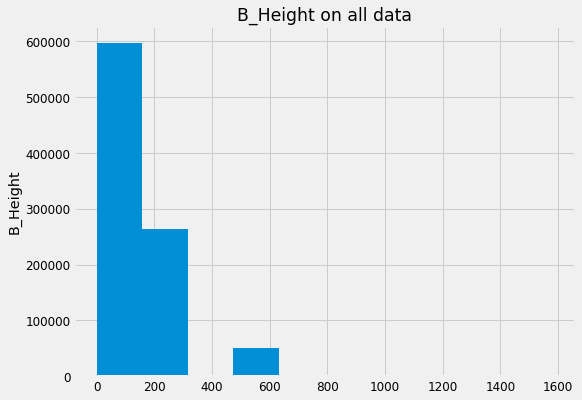

In [0]:
plt.hist(p_outliers["B_Height"])
plt.title("B_Height on outliers")
plt.ylabel("B_Height")
plt.show()
plt.clf()
plt.hist(p_alldata["B_Height"])
plt.title("B_Height on all data")
plt.ylabel("B_Height")
plt.show()

Height - Looking at the height, on the whole data most of height is quite small and most of it falls between 0 to 300. On the outlires on the other the situation is more diverse and while there are values from the pervious range its in much smaller percentage, the largest amount of records are around 1000 than high height can be used as a incudtion for an anomaly

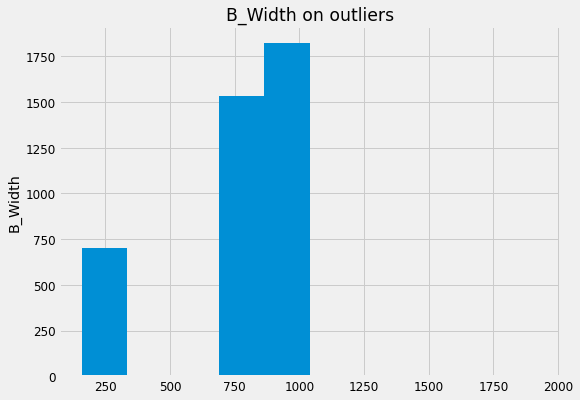

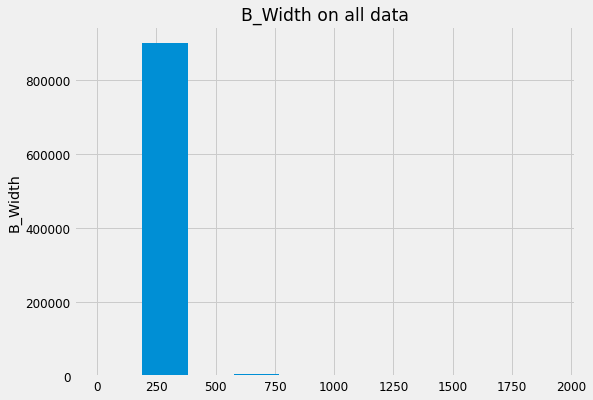

In [0]:
plt.hist(p_outliers["B_Width"])
plt.title("B_Width on outliers")
plt.ylabel("B_Width")
plt.show()
plt.clf()
plt.hist(p_alldata["B_Width"])
plt.title("B_Width on all data")
plt.ylabel("B_Width")
plt.show()

B_Width -  Having a look at B_width we can see that in the whole data most of the width is around 250, on the other hand in the outilers a large number of the mass is from 750 to 1000 which can helps us characterize the anomalies.

## CSV

those result are for all the data - so to get the resut only on files 5-6 like the one we submitted, needs to change the for in the begginning to get only this part of the data.

In [0]:
p_outliers = new_df_kmeans.select('y_pred').toPandas()
p_outliers.to_csv("q6_318170917_322995358.csv", header=True,index=False)

## investagation

As we mentioned in class, we think that we can get fake recorded by investigating the time and location of each user. to find out, we grouped by the user ip's and count the unique values of citys that they had "visit" in this time frame. as you see below, most users have a reasonable result, while 0.35 percent visited 4-7 cities in this time frame. *ip number that looks like 255.255.255.2__ is not relevent for our use - it represent something else

In [0]:
filelist = [ prefix + 'requestLog_D_919539.log.tar_' + str(i) + ".json" for i in [5,6]]
fname_ref = "bids_12.json"
inferred = spark.read.json("/mnt/lab94290/inputdata/"+fname_ref)
bids = spark.read.schema(inferred.schema).json(filelist)
out = json_flattening(inferred.select("device").schema)
device_flat_df = inferred.select(out)
out = [s.replace(".", "_") for s in out]
for column in device_flat_df:
    device_flat_df = device_flat_df.withColumnRenamed(str(column)[8:-2], out[0])
    out = out[1:]
bids = bids.drop('unparseable')
bids = bids.drop('unparseable').drop('domain')
out = json_flattening(bids.select('device','imp','location').schema)
out.remove('device.h')
out.remove('imp.banner.w')

flat_df = bids.select(out)
out = [s.replace(".", "_") for s in out]

for column in flat_df:
  flat_df = flat_df.withColumnRenamed(str(column)[8:-2], out[0])
  out = out[1:]
cols = ('imp_instl','imp_ext_wopv','imp_ext_viewabilityvendors','imp_ext_to','imp_ext_skadn_versions','imp_ext_skadn_version','imp_ext_skadn_sourceapp','imp_ext_skadn_skadnetids','imp_bidfloorcur','imp_banner_mimes','imp_banner_btype','imp_banner_battr','device_pxratio','device_ppi','device_lmt','device_w','device_ext_atts','device_ext_atts','device_ext_is_app','device_hwv')
flat_df = flat_df.drop(*cols)

most_popular_device_geo_city = flat_df.groupBy("device_geo_city").count().sort('count').collect()[-2][0]
flat_df = flat_df.na.fill(value=most_popular_device_geo_city, subset=['device_geo_city'])

flat_df = flat_df.na.fill(value="unknown", subset=['device_ip'])
flat = indexed_df_outliers.na.fill(value="unknown", subset=['device_ip']).toPandas()
ip_df = flat_df.groupBy(["device_ip"]).agg(countDistinct("device_geo_city").alias('citycount')).toPandas()
combined = flat.join(ip_df.set_index('device_ip'), on='device_ip')
print(len(combined))
df=spark.createDataFrame(combined)
df = df.na.fill(value=0, subset="citycount")
ouliers_col_df = f.udf(lambda citycount: 1 if 4<citycount<7 else 0, IntegerType())
df = df.withColumn('y_pred',ouliers_col_df(f.col('citycount')))
outliers_df = df.filter(f.col("y_pred") == 1)
df.show()
print((outliers_df.count()/df.count())*100)
p_outliers = df.toPandas()
q6_pred = p_outliers['y_pred'].astype("string").to_frame().reset_index()
q6_pred.to_csv("y_pred.csv", header=True,index=False)
len(p_outliers)

915878
+----------+--------+----------+------------------+-----------------+------------------+---------+--------------+--------+-------+------------+--------------+---------+------+
|B_Position|B_Secure|D_Geo_Type|         D_Geo_Lon|D_Connection_Type|             D_Lat|device_os|imp_banner_pos|B_Height|B_Width|imp_banner_h|     device_ip|citycount|y_pred|
+----------+--------+----------+------------------+-----------------+------------------+---------+--------------+--------+-------+------------+--------------+---------+------+
|         0|     1.0|       1.0|              null|              2.0|              null|      ios|           0.0|    50.0|  320.0|        50.0| 183.88.77.137|      0.0|     0|
|         0|     1.0|       1.0|          -49.2396|              2.0|          -25.5185|  android|           0.0|   250.0|  300.0|       250.0| 189.36.252.41|      2.0|     0|
|         1|     1.0|       1.0|          -104.621|              2.0|           38.2873|      ios|           1.0|

in the dataframe above you can see the 2 last coulmns - citycount which count the number of unique cities that this ip visit and y_pred - the ones that are in the threshold 4 to 7.

In [0]:
indexed_df = index(bids,False)

In [0]:
indexed_df.select(["B_Position","B_Secure","D_Geo_Lon","D_Lat","imp_banner_pos","B_Height","B_Width","imp_banner_h"]).describe().show()
outliers_df.select(["B_Position","B_Secure","D_Geo_Lon","D_Lat","imp_banner_pos","B_Height","B_Width","imp_banner_h"]).describe().show()

+-------+------------------+-------------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|summary|        B_Position|           B_Secure|        D_Geo_Lon|             D_Lat|    imp_banner_pos|          B_Height|           B_Width|      imp_banner_h|
+-------+------------------+-------------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|  count|            915879|             839450|           748983|            748922|            906603|            840372|            840372|            840372|
|   mean| 0.613590878271038| 0.7791673119304307|-8.86600017080981|19.330384041991497|0.6145644786086082|148.70293155888106|318.69810393492406|148.70293155888106|
| stddev|1.5556389565092181|0.41480816882506655|66.12947635315592| 21.73946946721593| 1.554300885289941|138.26008420459473| 57.90870569789179|138.26008420459473|
|    min|                 0|

In [0]:
p_outliers = outliers_df.toPandas()
p_alldata = indexed_df.toPandas()

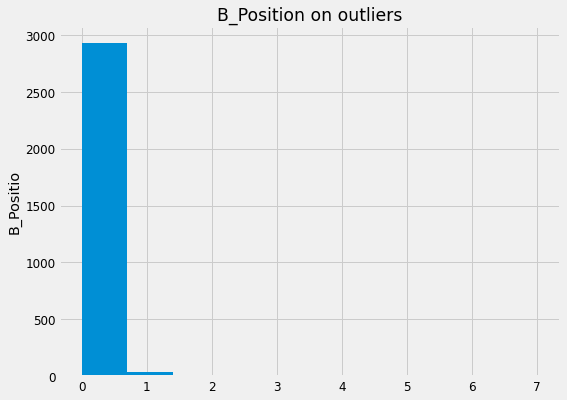

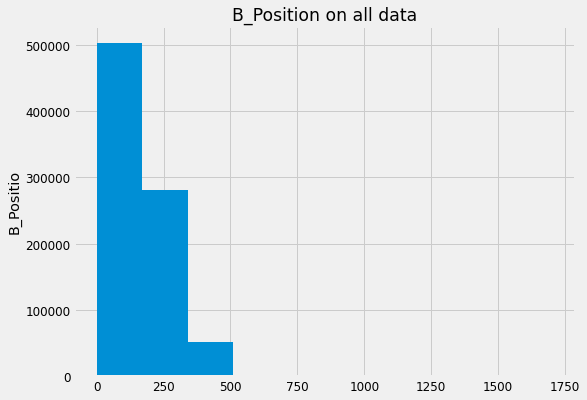

In [0]:
plt.hist(p_outliers["B_Position"])
plt.title("B_Position on outliers")
plt.ylabel("B_Positio")
plt.show()
plt.clf()
plt.hist(p_alldata["B_Height"])
plt.title("B_Position on all data")
plt.ylabel("B_Positio")
plt.show()

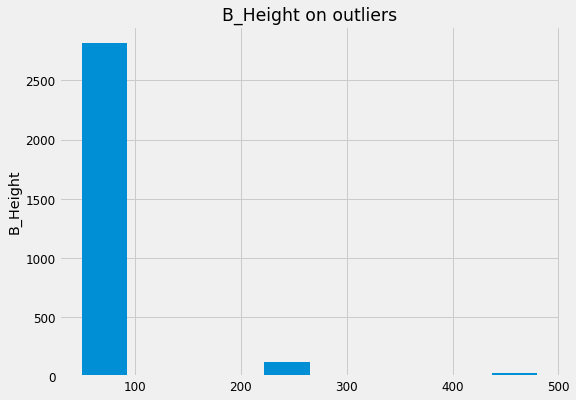

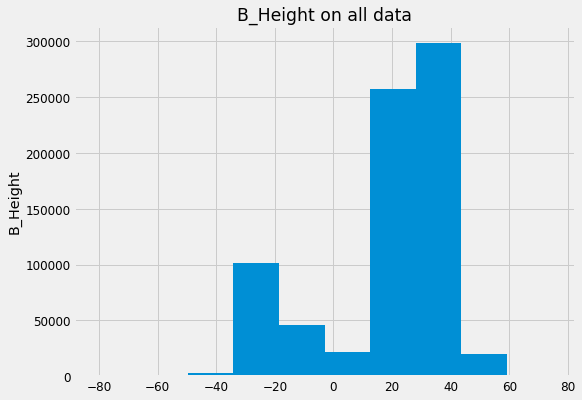

In [0]:
plt.hist(p_outliers["B_Height"])
plt.title("B_Height on outliers")
plt.ylabel("B_Height")
plt.show()
plt.clf()
plt.hist(p_alldata["D_Lat"])
plt.title("B_Height on all data")
plt.ylabel("B_Height")
plt.show()

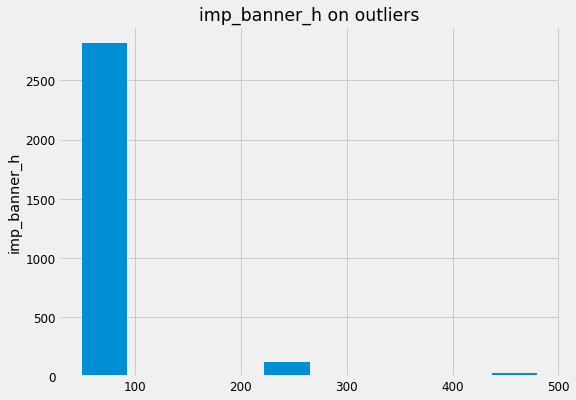

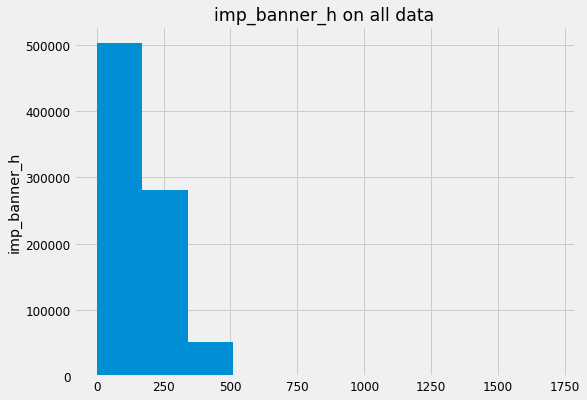

In [0]:
plt.hist(p_outliers["imp_banner_h"])
plt.title("imp_banner_h on outliers")
plt.ylabel("imp_banner_h")
plt.show()
plt.clf()
plt.hist(p_alldata["imp_banner_h"])
plt.title("imp_banner_h on all data")
plt.ylabel("imp_banner_h")
plt.show()

We can see that the graphs in general are very similar, the main difference between them is the graph of the outlier are more concentrated in the most frequent point which we explain by the small number they have compared to the general data

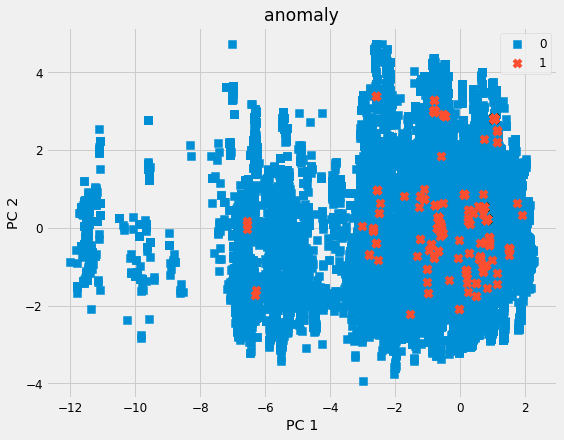

In [0]:
x_pca = df_pca[['pcaFeatures']].collect()
X_pca = np.array(x_pca)
first_pca = [x[0][0] for x in X_pca]
second_pca = [x[0][1] for x in X_pca]
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12
def plot_classes_pca(X_pca, y):
    markers = 's', 'x','.','*',"+"
    colors = list(plt.rcParams['axes.prop_cycle'])
    target = np.unique(y)
    for idx, (t, m) in enumerate(zip(target, markers)):
        subset = X_pca[y == t]
        plt.scatter(subset[:, 0], subset[:, 1], s = 50,
                    c = colors[idx]['color'], label = t, marker = m)

    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.legend(loc = 'upper right')
    plt.tight_layout()
    plt.title("anomaly")
    plt.show()
plot_classes_pca(X_pca, df[["y_pred"]].collect())

We can see that in this case the point on the left aren't classified as outliers which is a major difference. The outliers are mainly the points within the mass of points on the right which is surprising to see.

We saw that the outliers has the same distebution as the all data, it led us questioning: maybe those aren't actually outliers and anomaly? or maybe someone filled there data according to the other data so it will look normal?
this is an intersting result, that can be research more in further works.